### Import Libraries

In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

### Parameters

In [289]:
params = {
    'bsize' : 128,# Batch size during training.
    'b_output':128, # output from first Dense layer
    'imsize' : 64,# Spatial size of training images. All images will be resized to this size during preprocessing.
    'nc' : 3,# Number of channles in the training images. For coloured images this is 3.
    'nz' : 100,# Size of the Z latent vector (the input to the generator).
    'nepochs' : 100,# Number of training epochs.
    'lr' : 0.0002,# Learning rate for optimizers
    'beta1' : 0.5,# Beta1 hyperparam for Adam optimizer
    'beta2': 0.999, # Beta2 hyperparam for Adam optimizer
    'save_epoch' : 2 # Save step.
}

### Data preprocessing and Data Loader

In [134]:
# Dataset link
# https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg

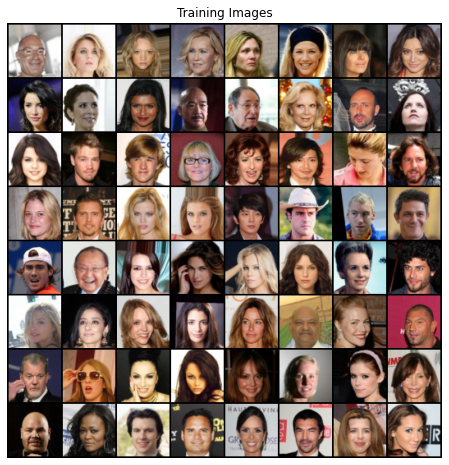

In [267]:
dataset_root = "data/"
transform = transforms.Compose([
    transforms.Resize(params['imsize']),
    transforms.CenterCrop(params['imsize']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

device = torch.device("cudo:0" if (torch.cuda.is_available()) else "cpu")
dataset = dset.ImageFolder(root=dataset_root, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['bsize'], shuffle=True)

sample_batch = next(iter(dataloader))


plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

### Generator Network

In [254]:
class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()

        # Input is the latent vector Z.
        self.linear1 = nn.Linear(params['nz'], params['b_output'])
        self.bn1 = nn.BatchNorm1d(params['b_output'], 0.8)
        
        # Input is b_output
        self.linear2 = nn.Linear(params['b_output'], params['b_output']*2)
        self.bn2 = nn.BatchNorm1d(params['b_output']*2, 0.8)
        
        # Input is b_output*2
        self.linear3 = nn.Linear(params['b_output']*2, params['b_output']*4)
        self.bn3 = nn.BatchNorm1d(params['b_output']*4, 0.8)
        
        # Input is b_output*3
        self.linear4 = nn.Linear(params['b_output']*4, params['b_output']*8)
        self.bn4 = nn.BatchNorm1d(params['b_output']*8, 0.8)
        
        # Input is b_output*4
        self.linear5 = nn.Linear(params['b_output']*8, params['imsize']*params['imsize']*params['nc'])

        
    def forward(self, img):
        img = F.leaky_relu(self.bn1(self.linear1(img)), 0.2)
        img = F.leaky_relu(self.bn2(self.linear2(img)), 0.2)
        img = F.leaky_relu(self.bn3(self.linear3(img)), 0.2)
        img = F.leaky_relu(self.bn4(self.linear4(img)), 0.2)
        img = F.tanh(self.linear5(img))
        
        img = img.view(params['bsize'], params['imsize'], params['imsize'], params['nc'])
        
        return img

#### Discriminator Network

In [303]:
class Discriminator(nn.Module):
    
    def __init__(self, params):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(params['imsize']**2*params['nc'], params['b_output']*8)
        self.linear2 = nn.Linear(params['b_output']*8, params['b_output']*4)
        self.linear3 = nn.Linear(params['b_output']*4, params['b_output']*2)
        self.linear4 = nn.Linear(params['b_output']*2, 1)
        
    def forward(self, img):
        img = img.view(img.shape[0], -1)
        img = F.leaky_relu(self.linear1(img), 0.2)
        img = F.leaky_relu(self.linear2(img), 0.2)
        img = F.leaky_relu(self.linear3(img), 0.2)
        img = F.linear4(img)
        
        return img

### Create Generator and Discriminator

In [304]:
netG = Generator(params)
netD = Generator(params)

In [305]:
cuda = True if torch.cuda.is_available() else False
if cuda:
    netG.cuda()
    netD.cuda()
    adversarial_loss.cuda()

In [306]:
print("Generator Network: ", netG)
print("Discriminator Network: ", netD)

Generator Network:  Generator(
  (linear1): Linear(in_features=100, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=512, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=1024, out_features=12288, bias=True)
)
Discriminator Network:  Generator(
  (linear1): Linear(in_features=100, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256,

### Optimizer

In [307]:
optimizer_G = torch.optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], params['beta2']))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], params['beta2']))

### Loss

In [308]:
adversarial_loss = torch.nn.BCELoss()

In [309]:
def log(x):
    return torch.log(x + 1e-8)

In [310]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [311]:
for epoch in range(params['nepochs']):
    for i, (img, _) in enumerate(dataloader):
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()
        batch_size = img.shape[0]
        
        #Adversarial ground truths
        g_target = 1 /(batch_size*2)
        d_target = 1/batch_size
        
        #configure input
        real_imgs = Variable(img.type(Tensor))
        
        #sample noise as generator input
        z = Variable(Tensor(np.random.normal(0,1,(img.shape[0], params['nz']))))
        gen_imgs = netG(z)
        
        d_real = netD(real_imgs)
        d_fake = netD(gen_imgs)
        
        #partition function
        z = torch.sum(torch.exp(-d_real)) + torch.sum(torch.exp(-d_fake))
        
        # Calculate the loss of discriminator and update
        d_loss = d_target*torch.sum(d_real)+log(z)
        d_loss.backward(retain_graph=True)
        optimizer_D.step()
        
        # Calculate the loss of generator and update
        g_loss = g_target*(torch.sum(d_real)+torch.sum(d_fake))+log(z)
        g_loss.backward()
        optimizer_G.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, params['nepochs'], i, len(dataloader), d_loss.item(), g_loss.item())
        )

RuntimeError: size mismatch, m1: [24576 x 64], m2: [100 x 128] at C:\w\b\windows\pytorch\aten\src\TH/generic/THTensorMath.cpp:41